In [198]:
# ---- LIBRARY IMPORTS ----
import pandas as pd
import datetime
import requests
from datetime import datetime
from haversine import haversine
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [194]:
# ---- Reading in datasets ----
usecols = [index for index in range(1, 14)]
dtype = {'ride_id': "string", 'rideable_type': "string", 'started_at': "string", 'ended_at': "string", 'start_station_name': "string",
         'start_station_id': "string", 'end_station_name': "string", 'end_station_id': "string", 'start_lat': float,
         'start_lng': float, 'end_lat': float, 'end_lng': float, 'member_casual': "string"}
df = pd.read_csv('data/202407-citibike-tripdata_5.csv', usecols=usecols, dtype=dtype)

In [195]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,557426B1CE207702,electric_bike,2024-07-17 19:30:15.471,2024-07-17 19:34:22.646,Sullivan St & Washington Sq,5721.01,E 12 St & 3 Ave,5788.12,40.730477,-73.999061,40.732233,-73.988900,member
1,A60E366FEE8B51E8,electric_bike,2024-07-15 19:17:52.523,2024-07-15 19:25:24.399,Sullivan St & Washington Sq,5721.01,Forsyth St & Grand St,5382.07,40.730477,-73.999061,40.717798,-73.993161,member
2,ACA30207F80B5DF9,classic_bike,2024-07-27 13:34:48.531,2024-07-27 13:49:55.913,W 37 St & 10 Ave,6611.02,Perry St & Bleecker St,5922.07,40.756604,-73.997901,40.735354,-74.004831,member
3,B3A138C956E9A729,electric_bike,2024-07-23 11:01:36.895,2024-07-23 11:06:02.796,Melrose St & Broadway,4801.04,Nostrand Ave & Myrtle Ave,4707.04,40.697481,-73.935877,40.695270,-73.952381,member
4,EA0BFE3B299B0672,electric_bike,2024-07-16 19:19:15.034,2024-07-16 19:50:39.140,Melrose St & Broadway,4801.04,W 27 St & 7 Ave,6257.06,40.697481,-73.935877,40.746650,-73.993920,member


# Data Cleansing
The following operations are required for data cleaning

1. Encode `rideable_type` and `member_casual`
2. Create fields for `start_date`, `start_time`, `end_date`, `end_time`
3. Create field for trip duration
4. Create distance between stations using the [Manhattan's Distance](https://www.datacamp.com/tutorial/manhattan-distance)
5. Drop any rows with missing station IDs

## Encoding Binary Variables
The `rideable_type` and `member_casual` fields will use dummy encoding using pandas' [`get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) method.

In [167]:
df = pd.get_dummies(data=df, columns=['rideable_type', 'member_casual'], dtype="int", drop_first=True)

## Drop any NA values
We want to drop any values with `Null` for missing station IDs, names, ride IDs, coordinates or names because if any of them are `Null`, then we cannot understand what what on during a ride.

In [168]:
df.dropna(subset=['ride_id', 'started_at', 'ended_at', 'start_station_name', 'start_station_id',
                  'end_station_id', 'end_station_name', 'start_lat', 'end_lat', 'end_lng', 'end_lng'], inplace=True)

## Create fields for `start_date`, `start_time`, `end_date`, `end_time`

In [169]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
date_map = lambda val: val.date()
time_map = lambda val: val.time()
df['start_date'] = df['started_at'].map(date_map)
df['end_date'] = df['ended_at'].map(date_map)
df['start_time'] =  df['started_at'].map(time_map)
df['end_time'] = df['ended_at'].map(time_map)

## Create field for trip_duration
We will now create the `trip_duration` field that describes the trip duration 

In [170]:
trip_duration = df['ended_at'] - df['started_at']
get_trip_seconds = lambda val: val.total_seconds()
df['trip_duration'] = trip_duration.map(get_trip_seconds)

## Get Distance Between All Stations
We now will capture the distances between all stations using the [Haversine Distance](https://pypi.org/project/haversine/), in meters.

In [171]:
def haversine_map(row):
    start_coordinates = (row['start_lat'], row['start_lng'])
    end_coordinates = (row['end_lat'], row['end_lng'])
    dist = haversine(start_coordinates, end_coordinates, unit="m")
    return dist

df['ride_dist'] = df.apply(haversine_map, axis=1)

# Analyze, Model, and Visualize
We aim to answer the below questions.

1. Which stations have longer trip times on average?
2. When are bikers most actively riding bikes?
3. Which stations have the receive bikes from the most stations? Which stations send bikes to the most stations?
4. Can we identify any monotonic relationships for future modeling?



## Question One
_Which stations have longer trip times on average?_
<!-- https://automating-gis-processes.github.io/2017/lessons/L3/point-in-polygon.html -->

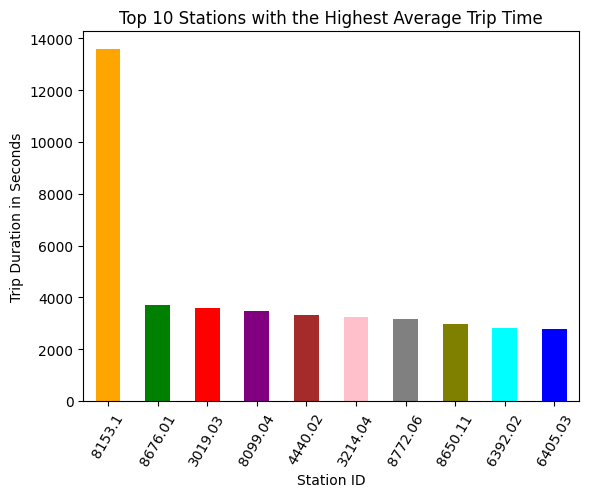

In [172]:
colors_trip_times = ['orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'blue']
trip_time_plot = df[["start_station_id", "trip_duration"]].groupby(by="start_station_id").mean("trip_duration").sort_values(by="trip_duration", ascending=False).head(10).plot.bar(
    y="trip_duration", color=colors_trip_times, title="Top 10 Stations with the Highest Average Trip Time", xlabel="Station ID", ylabel="Trip Duration in Seconds", rot=60, legend=False)
trip_time_plot.get_figure().savefig("img/trip_time_graph.png")

## Question Two
_When are bikers most actively riding bikes?_

In order to find when bikers are most active, we will show categorize each ride's `start_time` field into morning, afternoon, evening, and night.  The hours of of these times of days are defined [here](https://www.britannica.com/dictionary/eb/qa/parts-of-the-day-early-morning-late-morning-etc)

|Part of Day|Time Interval|
|:---:|:---:|
|Morning|05:00:00 - 11:59:59|
|Afternoon|12:00:00 - 16:59:59|
|Evening|17:00:00 - 20:59:59|
|Night|21:00:00 - 04:59:59|

In [173]:
def time_categorizer(row):
    start_time = row['start_time']
    hour = start_time.hour
    if hour > 4 and hour < 12: 
        time_of_day = "morning"
    elif hour > 11 and hour < 17:
        time_of_day = "afternoon"
    elif hour > 16 and hour < 21:
        time_of_day = "evening"
    else:
        time_of_day = "night"
    return time_of_day
    
df['time_of_day'] = df.apply(time_categorizer, axis=1)

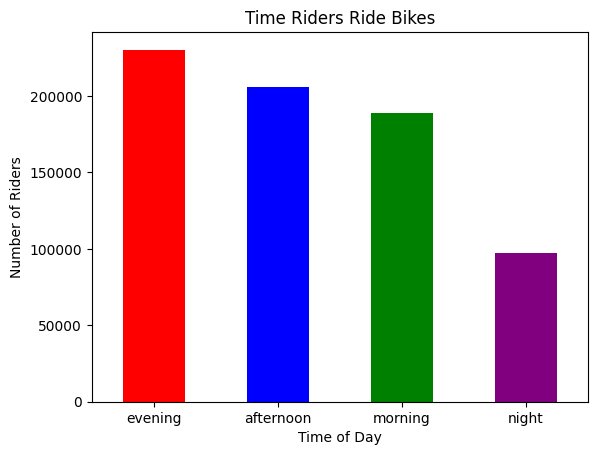

In [174]:
time_of_day_counts = df['time_of_day'].value_counts()
colors_time_of_day_counts = ['red', 'blue', 'green', 'purple']
time_riders_ride_plot = time_of_day_counts.plot.bar(color=colors_time_of_day_counts, rot=0, title="Time Riders Ride Bikes", xlabel="Time of Day", ylabel="Number of Riders")
time_riders_ride_plot.get_figure().savefig("img/time_riders_ride_bike_graph.png")

## Question Three
_Which stations have the receive bikes from the most stations?  Which stations send bikes to the most stations?_
<!-- Get the in-degree and out-degree -->

In [175]:
trips = df[["start_station_id", "end_station_id"]].groupby(["start_station_id", "end_station_id"], as_index=False).value_counts()
tuple_mapper = lambda row: (row["start_station_id"], row["end_station_id"], {"trip_count": row['count']})
x = list(trips.apply(tuple_mapper, axis=1))

In [176]:
g = nx.DiGraph()
g.add_edges_from(x)

In [177]:
in_degrees = dict(g.in_degree())
in_degrees = pd.Series(in_degrees.values(), index=in_degrees.keys())
in_degrees = in_degrees.sort_values(ascending=False).head(5)

out_degrees = dict(g.out_degree())
out_degrees = pd.Series(out_degrees.values(), index=out_degrees.keys())
out_degrees = out_degrees.sort_values(ascending=False).head(5)

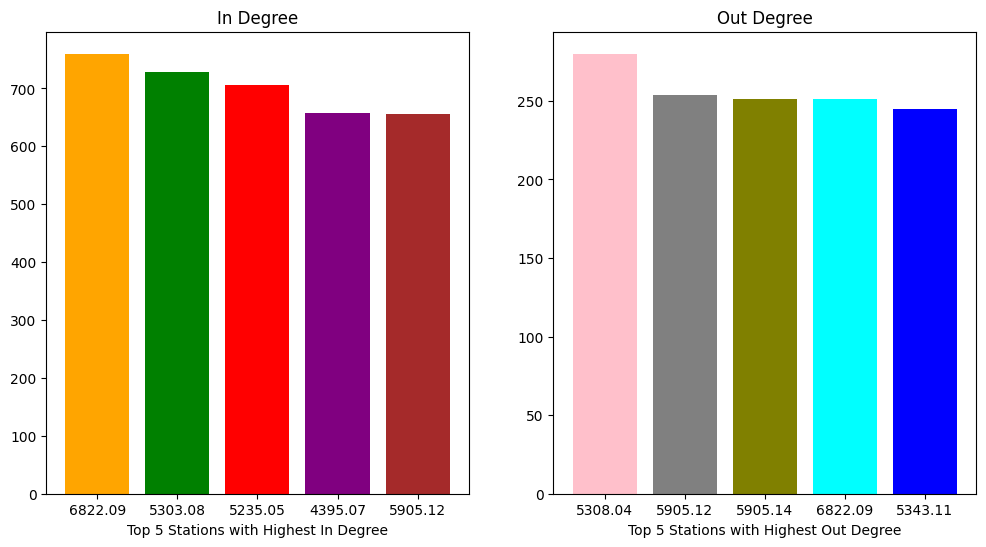

<Figure size 640x480 with 0 Axes>

In [208]:
colors_in_degree = ['orange', 'green', 'red', 'purple', 'brown']
colors_out_degree = ['pink', 'gray', 'olive', 'cyan', 'blue']
fig, (ax_one, ax_two) = plt.subplots(1, 2, figsize=(12, 6))
ax_one.bar(in_degrees.index, in_degrees, color=colors_in_degree)
ax_two.bar(out_degrees.index, out_degrees, color=colors_out_degree)
ax_one.set_title("In Degree")
ax_one.set_xlabel('Top 5 Stations with Highest In Degree')
ax_two.set_title("Out Degree")
ax_two.set_xlabel('Top 5 Stations with Highest Out Degree')
plt.savefig("img/degree_measure.png")
plt.show()

## Question Four
_Exploratory EDA - Can we identify some patterns in the data?_


In [179]:
# Linear regression using time of day,bike type, member type lat, lon
# Ensemble methods using time of day,bike type, member type lat, lon
df.head(5)
col_to_delete = df.columns.to_series()
col_to_delete = col_to_delete.filter(regex="(end)|(_date$)|(_at$)|(_name$)|(_time$)|(ride_id)|(ride_dist)")

In [181]:
data = df.drop(col_to_delete, axis=1)

In [182]:
data = pd.get_dummies(data, columns=["time_of_day"], drop_first=True, dtype=int)
data.head()

,start_station_id,start_lat,start_lng,rideable_type_electric_bike,member_casual_member,trip_duration,time_of_day_evening,time_of_day_morning,time_of_day_night
0,5721.01,40.730477,-73.999061,1,1,247.175,1,0,0
1,5721.01,40.730477,-73.999061,1,1,451.876,1,0,0
2,6611.02,40.756604,-73.997901,0,1,907.382,0,0,0
3,4801.04,40.697481,-73.935877,1,1,265.901,0,1,0
4,4801.04,40.697481,-73.935877,1,1,1884.106,1,0,0


In [183]:
# ---- INDEXING STATION IDs ----
station_info_url = "https://gbfs.lyft.com/gbfs/2.3/bkn/en/station_information.json"
station_info_dict = requests.get(station_info_url).json()
station_info_list = station_info_dict.get("data").get("stations")

In [184]:
test = pd.DataFrame(station_info_list)
station_ids = list(test['short_name'])
station_ids = pd.DataFrame(enumerate(station_ids), columns=["id", "short_name"])

In [185]:
data = data.merge(station_ids, left_on="start_station_id", right_on="short_name")

In [186]:
data.drop(labels=["start_station_id", "short_name"], inplace=True, axis=1)

,start_lat,start_lng,rideable_type_electric_bike,member_casual_member,trip_duration,time_of_day_evening,time_of_day_morning,time_of_day_night,id
0,40.730477,-73.999061,1,1,247.175,1,0,0,1666
1,40.730477,-73.999061,1,1,451.876,1,0,0,1666
2,40.756604,-73.997901,0,1,907.382,0,0,0,309
3,40.697481,-73.935877,1,1,265.901,0,1,0,1074
4,40.697481,-73.935877,1,1,1884.106,1,0,0,1074
...,...,...,...,...,...,...,...,...,...
713011,40.758630,-73.975130,1,1,669.920,0,0,0,1222
713012,40.755733,-73.923661,1,1,678.759,0,0,1,1832
713013,40.689730,-73.933530,1,1,273.901,1,0,0,1470
713014,40.794165,-73.974124,1,1,694.703,0,0,0,404


### Correlation Matrix

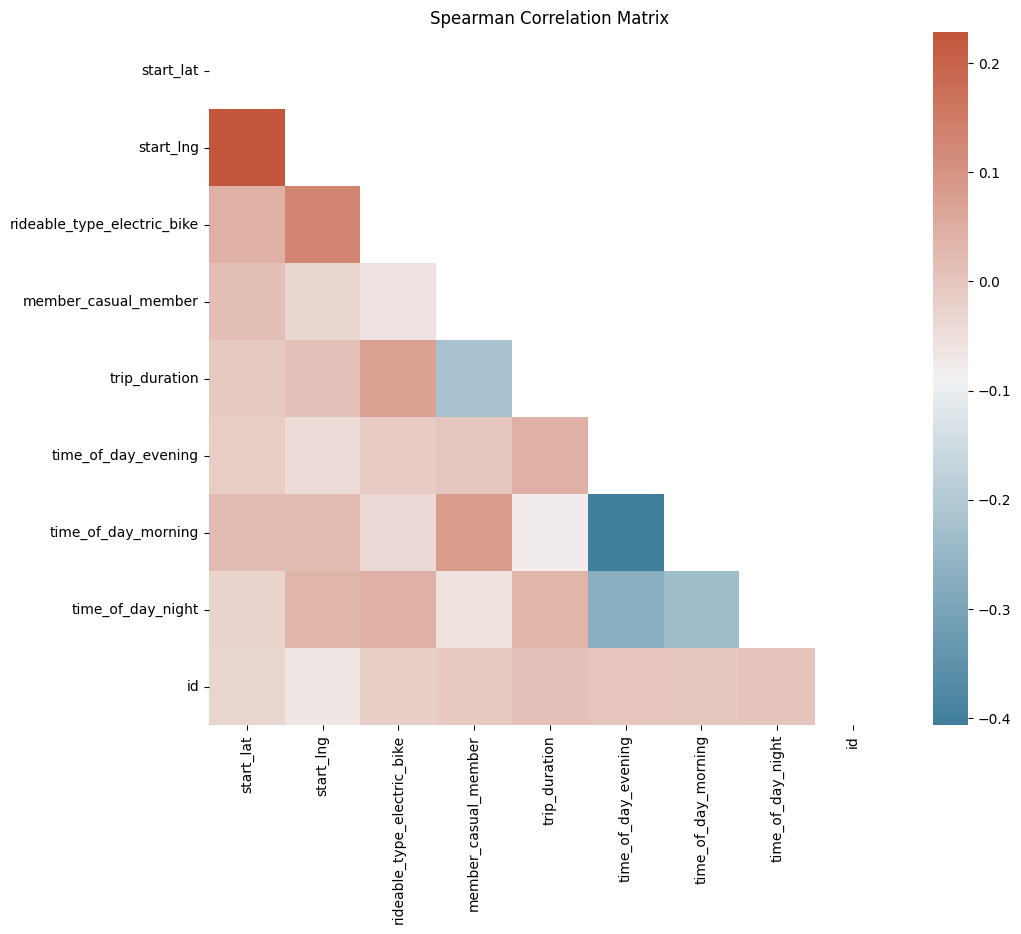

In [210]:
spearman_corr = data.corr("spearman")
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(spearman_corr, mask=mask, cmap=cmap)
ax.set_title("Spearman Correlation Matrix")
plt.savefig("img/correlation_matrix.png")
plt.show()

The Spearman correlation matrix allows us to understand whether or not variables contain a monotonic relationship.  Since majority of data weakly monotonic, therefore a model that can handle non-linear relationships such decision trees and neural networks might be more viable for prediction.